In [25]:
import numpy as np
from skimage import io, restoration
import cv2
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.fft import fft2, fftshift
from scipy import fftpack
from PIL import Image
from google.colab.patches import cv2_imshow

## **Gray Image Denoising using Anscombe transformation**


In [26]:
noised_image_gray = io.imread('/content/poissoned_gray.png')
noised_image_gray.shape

(200, 150, 3)

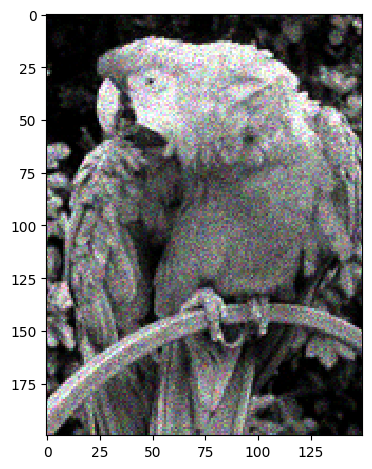

In [27]:
_ = io.imshow(noised_image_gray)

In [28]:
def anscombe(x):
    c = 3 / 8
    return 2 * np.sqrt(x + c)

def inv_anscombe(y):
    c = -1 * 3 / 8
    return np.power(0.5 * y, 2) + c

In [29]:
def depoisson(image):
    x = image / image.max()
    x = anscombe(x)
    x = restoration.denoise_tv_chambolle(x)
    x = inv_anscombe(x)
    return x

In [30]:
transformed_image = depoisson(noised_image_gray)
transformed_image.shape

(200, 150, 3)

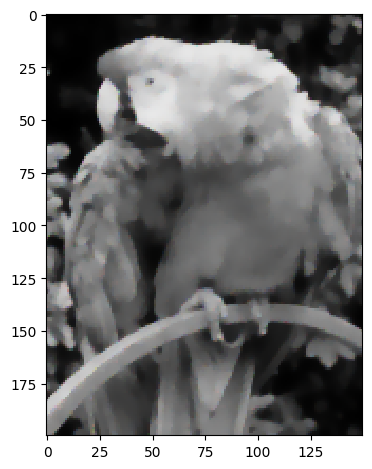

In [31]:
_ = io.imshow(transformed_image)

# **Colored Image Denoising using Fast Fourier Transformation**

Text(0.5, 1.0, 'Original')

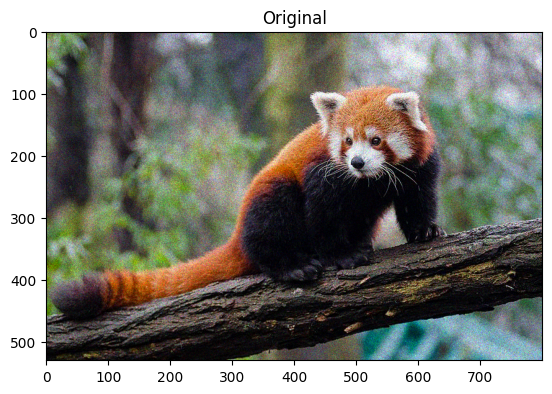

In [32]:
# Import and display image
image_path = "/content/poissoned_panda.png"
img = np.array(Image.open(image_path))
plt.figure()
plt.imshow(img)
plt.title('Original')

In [33]:
# Function to display each channel of the image
def display_transformed_img(img_fft):
    absolute_values = np.abs(img_fft)

    plt.figure(figsize=(12, 4))

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(fftshift(absolute_values[:, :, i]), norm=LogNorm(vmin=5))
        plt.title(f'Channel {i + 1}')
        plt.colorbar()

    plt.tight_layout()

<Figure size 640x480 with 0 Axes>

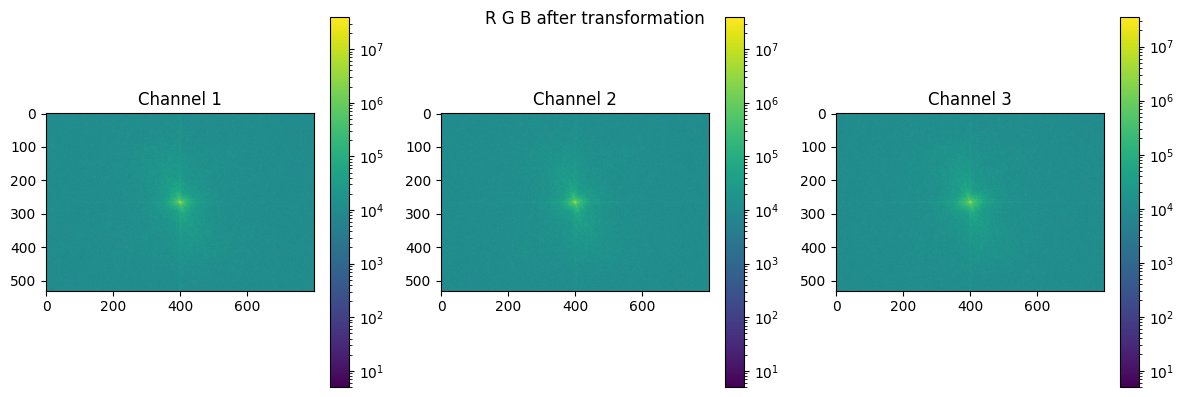

In [34]:
# Passing the image through fft
img_fft = np.fft.fft2(img, axes=(0, 1))

# Displaying the image
plt.figure()
display_transformed_img(img_fft)
plt.suptitle('R G B after transformation')
plt.show()

In [35]:
def filter_channel(channel_fft):
    channel_fft[-450:,-800:] = 0

    return channel_fft

In [36]:
# Apply filter to each channel
def denoise_image(img_fft):
    denoised_img_fft = np.zeros_like(img_fft, dtype=np.complex128)

    for i in range(3):
        denoised_img_fft[:, :, i] = filter_channel(img_fft[:, :, i])

    return denoised_img_fft

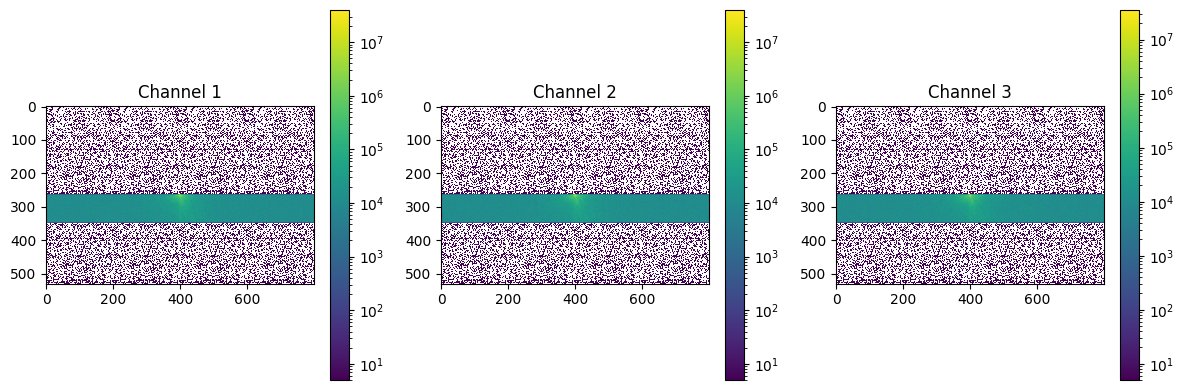

In [37]:
# Filtering the entire image
denoised_img_fft = denoise_image(img_fft)

# displaying R G and B values in fourier
display_transformed_img(denoised_img_fft)

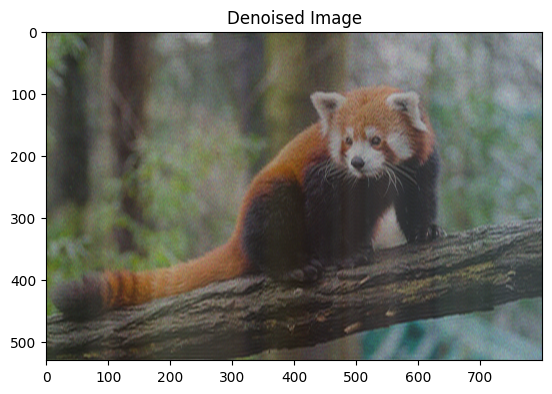

In [38]:
# Inverse fourier transform - from frourier to normal image
denoised_img = np.fft.ifft2(denoised_img_fft, axes=(0, 1)).real

plt.figure()
plt.imshow(np.uint8(denoised_img))
plt.title('Denoised Image')
plt.show()

# **Gray Image Compression**

In [39]:
def compress(image, compression_ratio):
    # Wykonaj dyskretną transformację Fouriera
    freq_image = np.fft.fft2(image)

    # Sortuj współczynniki według amplitudy
    sorted_freq_image = np.sort(np.abs(freq_image.flatten()))

    # Oblicz prog dla współczynników do wyzerowania
    threshold = sorted_freq_image[int((1 - compression_ratio) * len(sorted_freq_image))]

    # Wyzeruj współczynniki poniżej progu
    freq_image[np.abs(freq_image) < threshold] = 0

    # Wykonaj odwrotną transformację Fouriera
    compressed_image = np.fft.ifft2(freq_image).real

    return compressed_image

In [40]:
def evaluate_compression(original, compressed):
    # Oblicz Mean Absolute Error (MAE)
    mae = np.mean(np.abs(original - compressed))

    # Oblicz stopień kompresji (C)
    compression_ratio = original.size / compressed.size

    return mae, compression_ratio

In [41]:
# Wczytaj obraz szary
gray_image = cv2.imread('/content/gray_parrot.png', cv2.IMREAD_GRAYSCALE)

# Skompresuj obraz z wybranym współczynnikiem kompresji
compression_ratio = 0.1
compressed_image = compress(gray_image, compression_ratio)

In [42]:
# Ocen jakość kompresji
mae, c = evaluate_compression(gray_image, compressed_image)

Mean Absolute Error (MAE): 8.611369264631833
Compression Ratio (C): 1.0


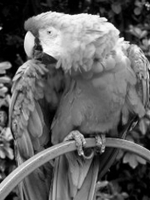

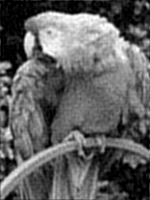

In [43]:
# Wyświetl wyniki
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Compression Ratio (C): {c}")

# Wyświetl oryginalny, skompresowany i zdekompresowany obraz
cv2_imshow(gray_image)
cv2_imshow(compressed_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


# **Colored Image Compression**

In [44]:
def compress_color_image(image, compression_ratio):
    # Podziel obraz na kanały kolorów
    b, g, r = cv2.split(image)

    # Kompresja dla każdego kanału
    compressed_b = compress(b, compression_ratio)
    compressed_g = compress(g, compression_ratio)
    compressed_r = compress(r, compression_ratio)

    # Złóż skompresowane kanały z powrotem do obrazu kolorowego
    compressed_image = cv2.merge([compressed_b, compressed_g, compressed_r])

    return compressed_image


In [45]:
# Wczytaj obraz kolorowy
color_image = cv2.imread('/content/red_panda.jpg')

# Skompresuj obraz z wybranym współczynnikiem kompresji
compression_ratio = 0.05
compressed_color_image = compress_color_image(color_image, compression_ratio)

In [46]:
# Ocen jakość kompresji
mae, c = evaluate_compression(color_image, compressed_color_image)

Mean Absolute Error (MAE): 6.866942643269033
Compression Ratio (C): 1.0


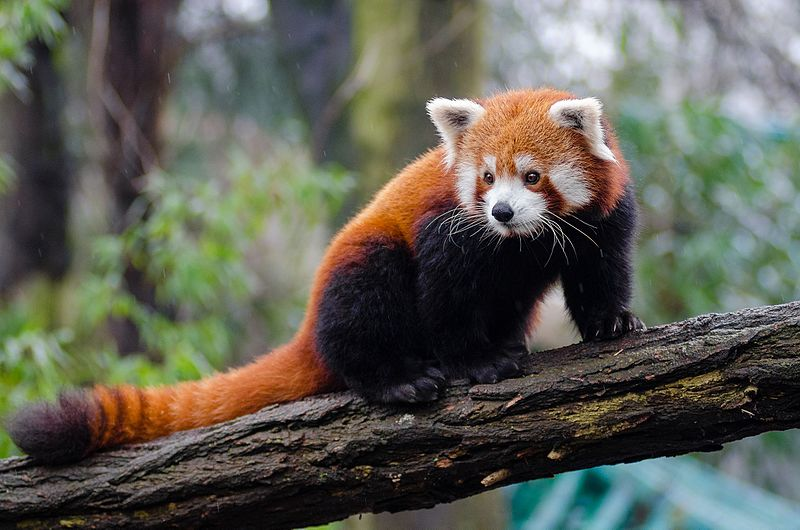

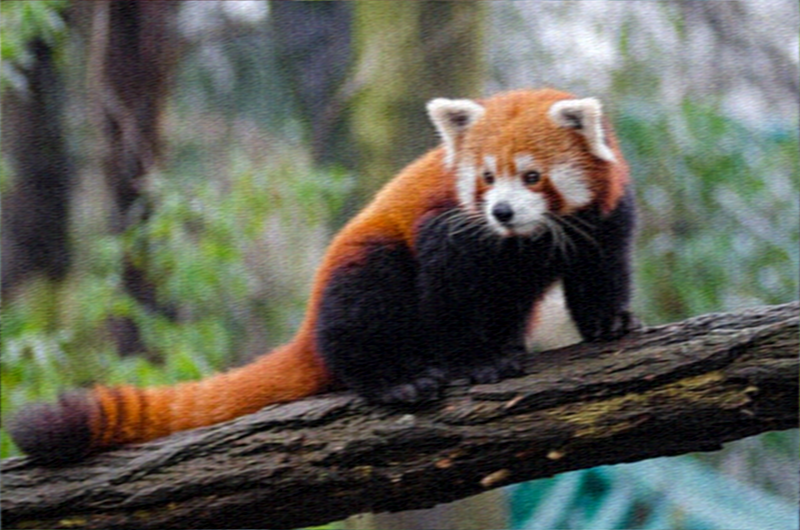

In [47]:
# Wyświetl wyniki
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Compression Ratio (C): {c}")

# Wyświetl oryginalny, skompresowany i zdekompresowany obraz (do weryfikacji)
cv2_imshow(color_image)
cv2_imshow(compressed_color_image)
cv2.waitKey(0)
cv2.destroyAllWindows()